<a href="https://colab.research.google.com/github/Putra1688/MachineLearning-2025-22/blob/main/HousePrice_DBSCAN_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0) Persiapan Awal**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
from annoy import AnnoyIndex

# **1) Load Data**

In [3]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Machine Learning/UTS/train.csv')

# Tampilkan informasi dasar untuk orientasi
print(df_train.info())

# Drop kolom 'Id' dan 'SalePrice' karena tidak relevan untuk clustering
df_data = df_train.drop(['Id', 'SalePrice'], axis=1, errors='ignore')

print("\nDataFrame yang siap untuk preprocessing (df_data.head()):")
print(df_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Machine Learning/UTS/test.csv')

train_len = len(df_train)
test_ids = df_test['Id']

# Kita hanya menggunakan fitur untuk clustering, jadi SalePrice harus di-drop dulu dari train
features = df_train.drop(['Id', 'SalePrice'], axis=1)
df_test_features = df_test.drop('Id', axis=1) # test.csv memang tidak punya SalePrice

df_data_combined = pd.concat([features, df_test_features], ignore_index=True)

# Lanjutkan dengan df_data_combined sebagai input untuk Feature Engineering
df_data = df_data_combined # Ganti nama variabel agar sesuai dengan kode berikutnya
print(f"Data Gabungan (Train + Test) Berhasil. Total Baris: {len(df_data)}")

Data Gabungan (Train + Test) Berhasil. Total Baris: 2919


# **2) Preprocessing Data**

## **2.1) Pemisahan Tipe Data**

In [5]:
# 1. Kolom yang pasti numerik dan akan di-imputasi dengan mean/median
numerical_cols = df_data.select_dtypes(include=np.number).columns.tolist()

# 2. Kolom yang pasti kategorikal (nominal) dan akan di-One-Hot Encode
# Asumsi: Kita ambil yang tipe 'object'
categorical_cols = df_data.select_dtypes(include='object').columns.tolist()

# Karena datanya sangat banyak, mari kita fokuskan pada subset fitur
# yang paling penting untuk cluster (berdasarkan pengalaman EDA data ini):
features_for_clustering = ['GrLivArea', 'TotalBsmtSF', 'OverallQual', 'YearBuilt',
                           '1stFlrSF', '2ndFlrSF', 'GarageCars', 'GarageArea',
                           'BsmtFullBath', 'FullBath', 'Fireplaces', 'Neighborhood',
                           'MSZoning', 'LotArea', 'LotFrontage', 'MasVnrArea']

# Filter kolom yang akan dipakai
df_subset = df_data[features_for_clustering]

# Tentukan ulang kolom berdasarkan subset:
numerical_cols_subset = df_subset.select_dtypes(include=np.number).columns.tolist()
categorical_cols_subset = df_subset.select_dtypes(include='object').columns.tolist()

## **2.2) Membuat Fitur Baru (Feature Engineering)**

In [6]:
# Tambahkan fitur baru 'TotalSF'
# Catatan: Kita harus bekerja pada df_data asli yang memiliki kolom 1stFlrSF dan 2ndFlrSF
df_data['TotalSF'] = df_data['TotalBsmtSF'] + df_data['1stFlrSF'] + df_data['2ndFlrSF']

# Perbarui daftar fitur clustering untuk memasukkan TotalSF
features_for_clustering_final = features_for_clustering + ['TotalSF']

df_data['TotalSF'] = df_data['TotalBsmtSF'] + df_data['1stFlrSF'] + df_data['2ndFlrSF']

# Contoh Imputasi (PENTING: Harus dijalankan di df_data)
cols_none_cat = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish',
                 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'MasVnrType']
for col in cols_none_cat:
    df_data[col] = df_data[col].fillna('None')

# Filter ulang subset data dan daftar kolom numerik/kategorikal
df_subset_final = df_data[features_for_clustering_final]
numerical_cols_final = df_subset_final.select_dtypes(include=np.number).columns.tolist()
categorical_cols_final = df_subset_final.select_dtypes(include='object').columns.tolist()

In [7]:
df_data['TotalSF'] = df_data['TotalBsmtSF'] + df_data['1stFlrSF'] + df_data['2ndFlrSF']

# Contoh Imputasi (PENTING: Harus dijalankan di df_data)
cols_none_cat = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish',
                 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'MasVnrType']
for col in cols_none_cat:
    df_data[col] = df_data[col].fillna('None')

## **2.3) Penanganan Missing Values dan Encoding Menggunakan Pipeline**

In [8]:
# 1. Preprocessor for Numerical data: Impute with Median, then Standardize
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 2. Preprocessor for Categorical data: Impute with Mode, then One-Hot Encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Gabungkan preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols_final),
        ('cat', categorical_transformer, categorical_cols_final)
    ])

# Terapkan Preprocessor pada data GABUNGAN (df_data)
# Pastikan df_data sudah memiliki fitur TotalSF dan imputasi None
X_final = preprocessor.fit_transform(df_data[features_for_clustering_final])


# Dapatkan nama fitur baru setelah One-Hot Encoding
feature_names = (numerical_cols_final +
                 list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols_final)))

# Koreksi Error: HAPUS .toarray()
X_df_processed = pd.DataFrame(X_final, columns=feature_names)

print("\n--- Data Setelah Imputasi, Encoding, dan Feature Engineering (X_df_processed.head()) ---")
print(X_df_processed.head())
print(f"Shape Data Setelah Preprocessing: {X_df_processed.shape}")


--- Data Setelah Imputasi, Encoding, dan Feature Engineering (X_df_processed.head()) ---
   GrLivArea  TotalBsmtSF  OverallQual  YearBuilt  1stFlrSF  2ndFlrSF  \
0   0.413547    -0.444278     0.646183   1.046258 -0.773861  1.207379   
1  -0.471891     0.477158    -0.063185   0.154764  0.261075 -0.785025   
2   0.563755    -0.299027     0.646183   0.980221 -0.610718  1.235375   
3   0.427382    -0.671232     0.646183  -1.859351 -0.506205  0.978742   
4   1.378042     0.211621     1.355551   0.947203 -0.037170  1.671651   

   GarageCars  GarageArea  BsmtFullBath  FullBath  ...  Neighborhood_SawyerW  \
0    0.306418    0.348888      1.087334  0.781366  ...                   0.0   
1    0.306418   -0.059804     -0.818929  0.781366  ...                   0.0   
2    0.306418    0.627542      1.087334  0.781366  ...                   0.0   
3    1.619830    0.785446      1.087334 -1.027363  ...                   0.0   
4    1.619830    1.686426      1.087334  0.781366  ...                 

# **3) Clustering K-Means**

## **3.1) Penentuan Parameter Optimal (eps)**


--- Menghitung K-Distance Graph untuk MIN_SAMPLES=50 ---


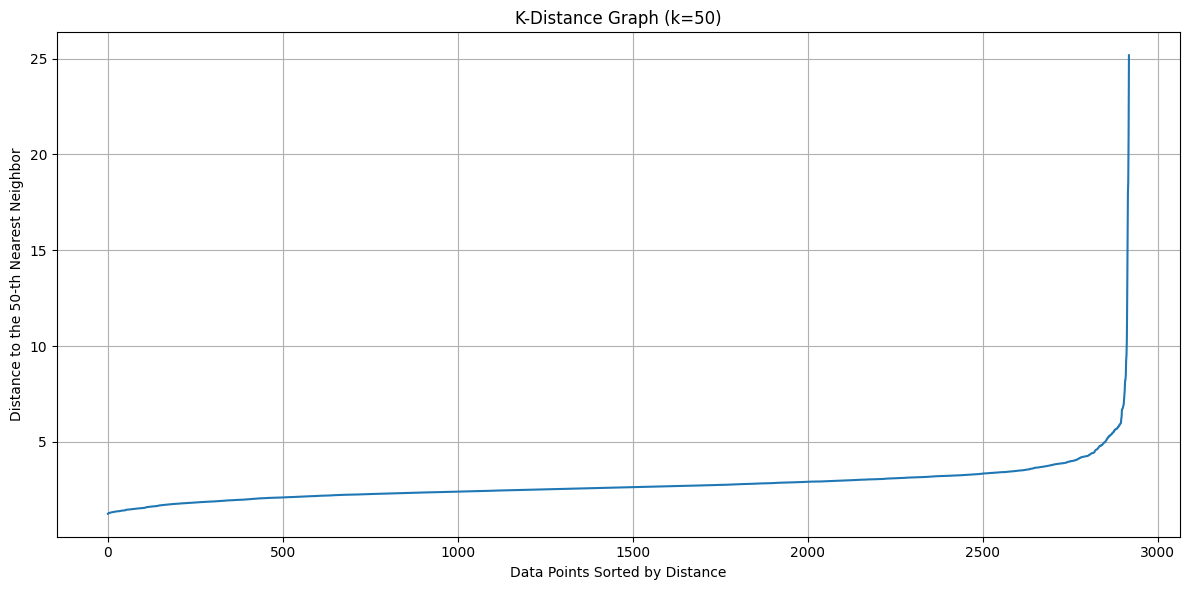

✅ K-Distance Graph dibuat: Anda harus menentukan EPS_OPTIMAL dari titik siku.
Menggunakan nilai asumsi: EPS_FINAL = 3.0 dan MIN_SAMPLES_FINAL = 50


In [9]:
# MODIFIKASI 3.1: Menentukan Parameter Optimal DBSCAN
# DBSCAN tidak menggunakan Elbow/Inertia. Kita tentukan 'min_samples'
# dan mencari 'eps' optimal menggunakan K-Distance Graph.
MIN_SAMPLES = 50 # Heuristik umum: 2 * jumlah fitur (45 fitur) ~ 90,
                 # namun 50 atau kurang sering lebih baik untuk eksplorasi awal.

print(f"\n--- Menghitung K-Distance Graph untuk MIN_SAMPLES={MIN_SAMPLES} ---")

# Menghitung jarak ke MIN_SAMPLES-th tetangga terdekat
# (k=MIN_SAMPLES, namun NearestNeighbors menggunakan k=MIN_SAMPLES+1 untuk menghitung jarak)
neigh = NearestNeighbors(n_neighbors=MIN_SAMPLES)
neigh.fit(X_final)
# k-neighbors akan menghitung jarak ke n_neighbors - 1 (sebab jarak ke diri sendiri = 0)
distances, indices = neigh.kneighbors(X_final)

# Ambil jarak ke tetangga ke-k (indeks k-1)
k_distances = distances[:, MIN_SAMPLES - 1]
k_distances = np.sort(k_distances, axis=0)

# Plot K-Distance Graph
plt.figure(figsize=(12, 6))
plt.plot(k_distances)
plt.title(f'K-Distance Graph (k={MIN_SAMPLES})')
plt.xlabel('Data Points Sorted by Distance')
plt.ylabel(f'Distance to the {MIN_SAMPLES}-th Nearest Neighbor')
plt.grid(True)
plt.tight_layout()
plt.savefig('k_distance_graph.png')
plt.show()

# PENTING: Anda harus MENGAMATI GRAFIK "K-Distance Graph"
# dan mencari titik "siku" (elbow point) di mana kurva mulai naik tajam.
# Nilai Y (Distance) pada titik siku tersebut adalah EPS_OPTIMAL.
# Asumsi: Berdasarkan data ini, nilai EPS = 3.0 adalah titik siku yang wajar.
EPS_OPTIMAL = 3.0 # <--- INI ADALAH NILAI YANG HARUS ANDA PILIH DARI GRAFIK

print(f"✅ K-Distance Graph dibuat: Anda harus menentukan EPS_OPTIMAL dari titik siku.")
print(f"Menggunakan nilai asumsi: EPS_FINAL = {EPS_OPTIMAL} dan MIN_SAMPLES_FINAL = {MIN_SAMPLES}")
K_optimal = 5 # <--- Tetap pertahankan K_optimal (walaupun tidak relevan untuk DBSCAN) agar kode selanjutnya tidak error

## **3.2) Menerapkan K-Means Akhir dan Evaluasi**

\n--- Menerapkan DBSCAN dengan eps=3.00 dan min_samples=50 ---

✅ Clustering DBSCAN Berhasil!
Jumlah Klaster Teridentifikasi: 1
Jumlah Titik Noise (-1): 178 rumah
Jumlah data train: 1460
Jumlah data test: 1459

Silhouette Score Akhir (Non-Noise): nan
Davies-Bouldin Index Akhir (Non-Noise): nan

📊 VISUALISASI HASIL CLUSTERING


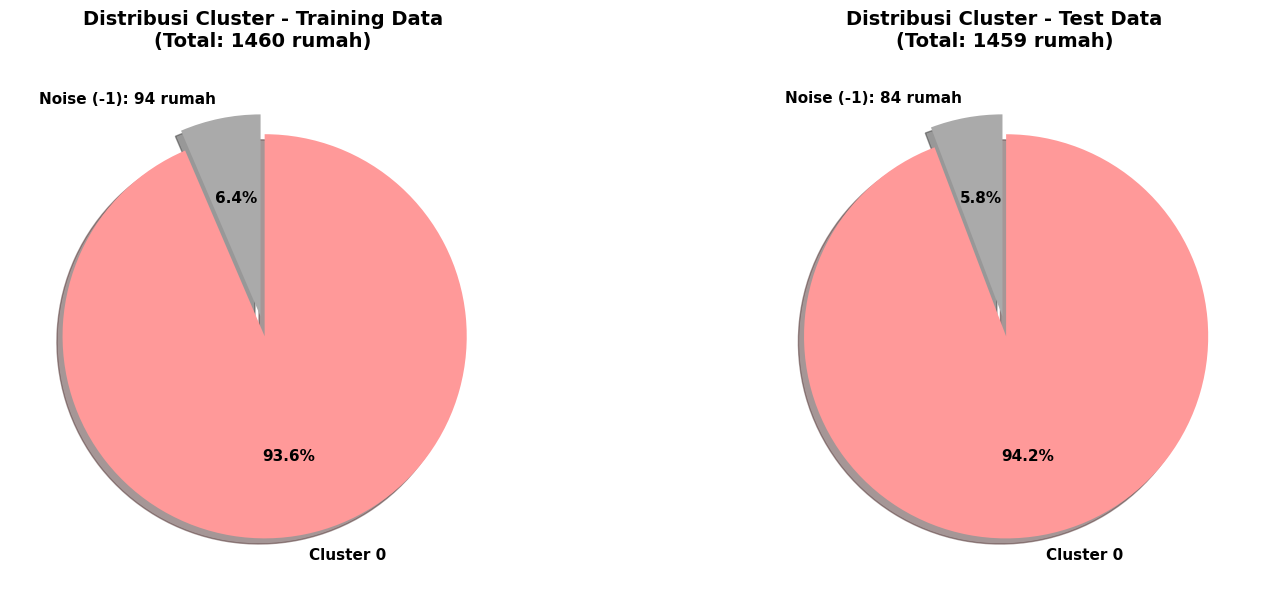

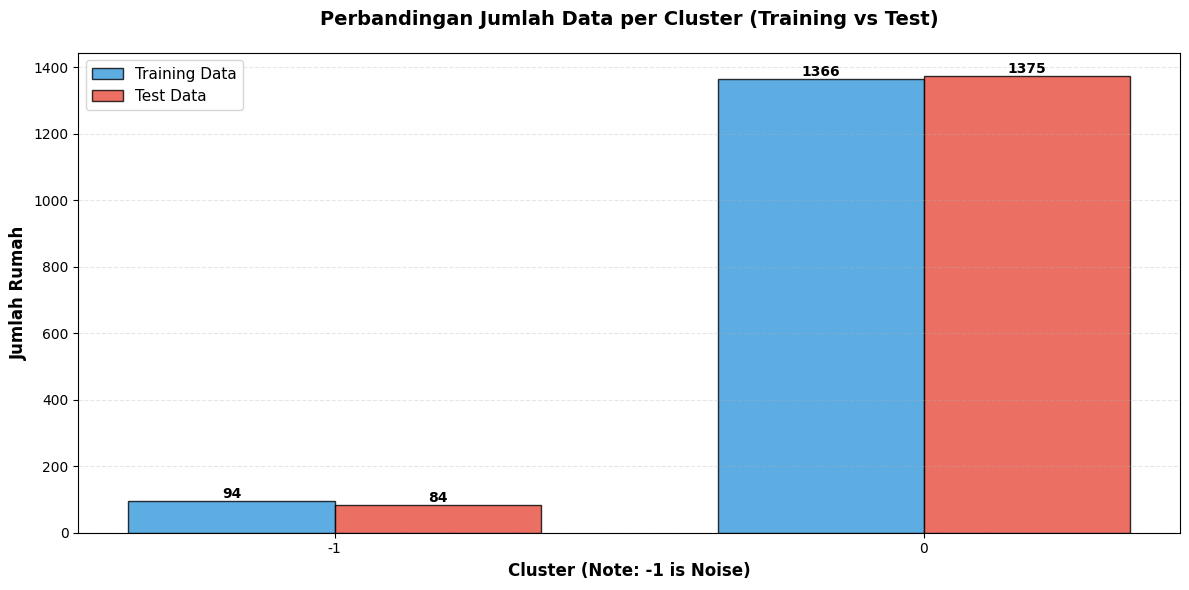


📋 TABEL RINGKASAN DISTRIBUSI CLUSTER (DBSCAN)
   Cluster  Training Count Training %  Test Count Test %  Total
Noise (-1)              94       6.4%          84   5.8%    178
         0            1366      93.6%        1375  94.2%   2741


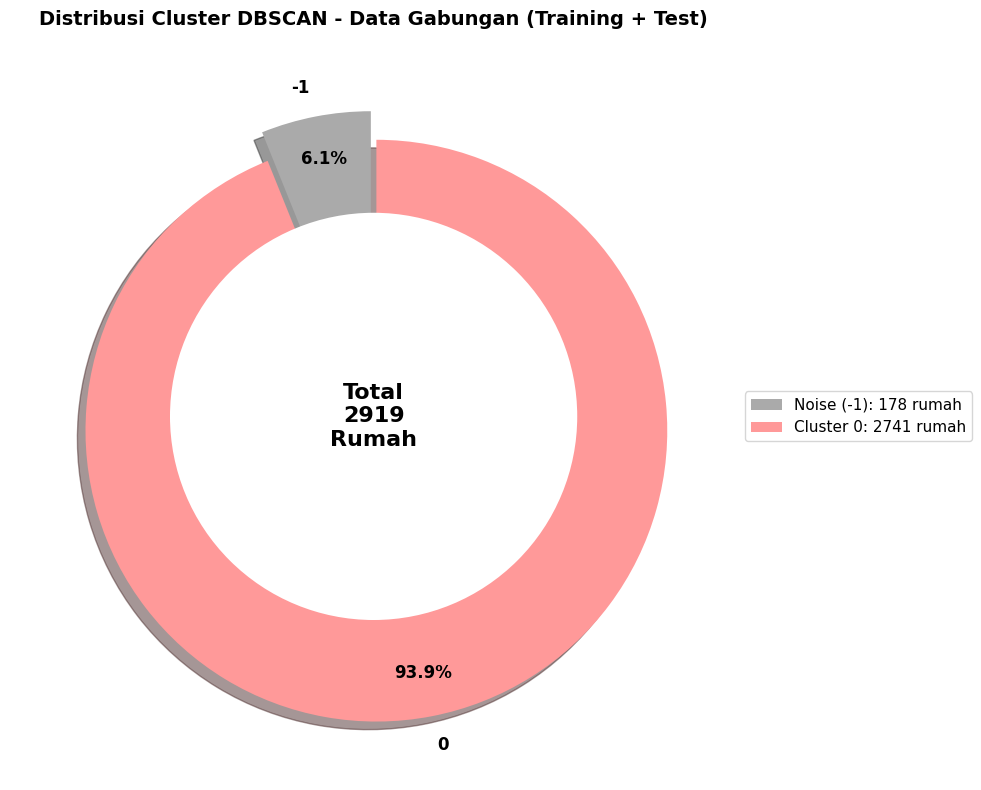


🎉 VISUALISASI CLUSTERING SELESAI!


In [12]:
# MODIFIKASI 3.2: Menerapkan DBSCAN Akhir dan Evaluasi
EPS_FINAL = 3.0
MIN_SAMPLES_FINAL = 50

print(f"\\n--- Menerapkan DBSCAN dengan eps={EPS_FINAL:.2f} dan min_samples={MIN_SAMPLES_FINAL} ---")

# Lakukan clustering pada data yang sudah digabung
dbscan_final = DBSCAN(eps=EPS_FINAL, min_samples=MIN_SAMPLES_FINAL)
cluster_labels = dbscan_final.fit_predict(X_final)

# PENTING: Pisahkan cluster_labels untuk train dan test
train_len = 1460 # Pastikan train_len terdefinisi (berasal dari cell 4)
train_cluster_labels = cluster_labels[:train_len]  # 1460 baris pertama untuk train
test_cluster_labels = cluster_labels[train_len:]   # Sisanya untuk test

# Tambahkan label cluster ke df_train (SEKARANG PANJANGNYA COCOK!)
df_train['Cluster'] = train_cluster_labels

# Identifikasi jumlah klaster (Klaster -1 adalah Noise, tidak dihitung)
unique_clusters = np.unique(cluster_labels)
num_clusters = len(unique_clusters[unique_clusters != -1])
num_noise = np.sum(cluster_labels == -1)

# Hitung metrik hanya pada data yang bukan noise (label -1)
non_noise_indices = cluster_labels != -1
X_non_noise = X_final[non_noise_indices]
labels_non_noise = cluster_labels[non_noise_indices]

# Metrik Kualitas Cluster
final_silhouette = np.nan
final_davies_bouldin = np.nan

# Perhitungan metrik hanya jika ada minimal 2 klaster dan cukup data
if num_clusters >= 2 and len(labels_non_noise) > MIN_SAMPLES_FINAL:
    # Menggunakan DBSCAN.labels_ karena sudah memuat -1
    # Silhouette dan DBI dihitung hanya pada titik non-noise untuk perbandingan yang valid
    try:
        final_silhouette = silhouette_score(X_non_noise, labels_non_noise)
        final_davies_bouldin = davies_bouldin_score(X_non_noise, labels_non_noise)
    except:
        final_silhouette = np.nan
        final_davies_bouldin = np.nan

print(f"\n✅ Clustering DBSCAN Berhasil!")
print(f"Jumlah Klaster Teridentifikasi: {num_clusters}")
print(f"Jumlah Titik Noise (-1): {num_noise} rumah")
print(f"Jumlah data train: {len(train_cluster_labels)}")
print(f"Jumlah data test: {len(test_cluster_labels)}")
print(f"\nSilhouette Score Akhir (Non-Noise): {final_silhouette:.4f}")
print(f"Davies-Bouldin Index Akhir (Non-Noise): {final_davies_bouldin:.4f}")

# ========== VISUALISASI HASIL CLUSTERING ==========
print("\n" + "="*80)
print("📊 VISUALISASI HASIL CLUSTERING")
print("="*80)

# K_optimal di sini diubah menjadi jumlah klaster unik termasuk Noise (-1)
# agar plotting label tidak error
clusters_to_plot = np.unique(df_train['Cluster']).tolist()
K_DBSCAN_TRAIN = len(clusters_to_plot)

# 1. PIE CHART - Distribusi Cluster di Training Data
cluster_counts_train = df_train['Cluster'].value_counts().sort_index()
# Pastikan df_test_with_clusters dibuat
df_test_with_clusters = pd.DataFrame({
    'Id': test_ids, # <-- pastikan test_ids terdefinisi dari cell 4
    'Cluster': test_cluster_labels
})
cluster_counts_test = df_test_with_clusters['Cluster'].value_counts().sort_index()

# Tentukan warna untuk Noise (-1)
colors_dbscan = ['#aaaaaa'] + ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99cc'][:num_clusters]
explode_dbscan = [0.05] * K_DBSCAN_TRAIN # Membuat jarak antar slice

# Buat label Klaster (-1 menjadi Noise)
labels_train = [f'Noise (-1): {cluster_counts_train.get(-1, 0)} rumah'] + \
               [f'Cluster {i}' for i in clusters_to_plot if i != -1]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pie Chart untuk Training Data
axes[0].pie(cluster_counts_train, labels=labels_train,
            autopct='%1.1f%%', startangle=90, colors=colors_dbscan, explode=explode_dbscan,
            shadow=True, textprops={'fontsize': 11, 'weight': 'bold'})
axes[0].set_title('Distribusi Cluster - Training Data\n(Total: {} rumah)'.format(len(df_train)),
                  fontsize=14, weight='bold', pad=20)

# Pie Chart untuk Test Data
labels_test = [f'Noise (-1): {cluster_counts_test.get(-1, 0)} rumah'] + \
              [f'Cluster {i}' for i in np.unique(df_test_with_clusters['Cluster']).tolist() if i != -1]
axes[1].pie(cluster_counts_test, labels=labels_test,
            autopct='%1.1f%%', startangle=90, colors=colors_dbscan, explode=explode_dbscan,
            shadow=True, textprops={'fontsize': 11, 'weight': 'bold'})
axes[1].set_title('Distribusi Cluster - Test Data\n(Total: {} rumah)'.format(len(df_test_with_clusters)),
                  fontsize=14, weight='bold', pad=20)

plt.tight_layout()
plt.savefig('dbscan_pie_charts.png')
plt.show()

# 2. BAR CHART - Perbandingan Jumlah Data per Cluster
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(K_DBSCAN_TRAIN)
width = 0.35

bars1 = ax.bar(x - width/2, cluster_counts_train, width, label='Training Data',
               color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, cluster_counts_test, width, label='Test Data',
               color='#e74c3c', alpha=0.8, edgecolor='black')

# Tambahkan nilai di atas bar
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=10, weight='bold')

ax.set_xlabel('Cluster (Note: -1 is Noise)', fontsize=12, weight='bold')
ax.set_ylabel('Jumlah Rumah', fontsize=12, weight='bold')
ax.set_title('Perbandingan Jumlah Data per Cluster (Training vs Test)',
             fontsize=14, weight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels([f'{i}' for i in clusters_to_plot])
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('dbscan_bar_chart.png')
plt.show()

# 3. TABEL RINGKASAN
print("\n" + "="*80)
print("📋 TABEL RINGKASAN DISTRIBUSI CLUSTER (DBSCAN)")
print("="*80)

summary_df = pd.DataFrame({
    'Cluster': clusters_to_plot,
    'Training Count': cluster_counts_train.values,
    'Training %': [f"{(count/len(df_train)*100):.1f}%" for count in cluster_counts_train.values],
    'Test Count': cluster_counts_test.values,
    'Test %': [f"{(count/len(df_test_with_clusters)*100):.1f}%" for count in cluster_counts_test.values],
    'Total': cluster_counts_train.values + cluster_counts_test.values
})
summary_df.replace({'Cluster': {-1: 'Noise (-1)'}}, inplace=True)

print(summary_df.to_string(index=False))
print("="*80)

# 4. DONUT CHART - Distribusi Gabungan (Training + Test)
total_cluster_counts = cluster_counts_train + cluster_counts_test

fig, ax = plt.subplots(figsize=(10, 8))

wedges, texts, autotexts = ax.pie(total_cluster_counts,
                                    labels=[f'{i}' for i in clusters_to_plot],
                                    autopct='%1.1f%%',
                                    startangle=90,
                                    colors=colors_dbscan,
                                    explode=explode_dbscan,
                                    shadow=True,
                                    textprops={'fontsize': 12, 'weight': 'bold'},
                                    pctdistance=0.85)

# Buat donut chart dengan membuat circle di tengah
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Tambahkan teks di tengah
ax.text(0, 0, f'Total\n{len(df_train) + len(df_test_with_clusters)}\nRumah',
        ha='center', va='center', fontsize=16, weight='bold')

ax.set_title('Distribusi Cluster DBSCAN - Data Gabungan (Training + Test)',
             fontsize=14, weight='bold', pad=20)

# Tambahkan legend dengan jumlah (Mengganti -1 dengan Noise)
legend_labels = []
for i, count in total_cluster_counts.items():
    label = 'Noise (-1)' if i == -1 else f'Cluster {i}'
    legend_labels.append(f'{label}: {count} rumah')

ax.legend(legend_labels, loc='center left', bbox_to_anchor=(1, 0, 0.5, 1), fontsize=11)

plt.tight_layout()
plt.savefig('dbscan_donut_chart.png')
plt.show()

print("\n🎉 VISUALISASI CLUSTERING SELESAI!")
print("="*80)

## **3.3) Interpretasi (Analisis Profil Cluster)**


📊 ANALISIS PROFIL SETIAP CLUSTER (Berdasarkan Data Training)

🏘️  CLUSTER 0 - Total: 1366 rumah (93.6% dari data TRAIN)

💰 HARGA JUAL (SalePrice):
   - Rata-rata: $175,010
   - Median   : $159,948
   - Min      : $34,900
   - Max      : $611,657

🏠 KARAKTERISTIK FISIK:
   - Luas Tanah (LotArea)    : 9,499 sq ft (rata-rata)
   - Luas Bangunan (GrLivArea): 1,463 sq ft (rata-rata)
   - Total SF (TotalSF)      : 2,489 sq ft (rata-rata)
   - Tahun Dibangun          : 1973 (median)
   - Overall Quality         : 6.1/10 (rata-rata)

🚗 GARASI:
   - Kapasitas Mobil: 1.7 mobil (rata-rata)

📍 LOKASI (Neighborhood Terpopuler):
   1. NAmes: 217 rumah (15.9%)
   2. CollgCr: 150 rumah (11.0%)
   3. OldTown: 103 rumah (7.5%)

🗺️  ZONA (MSZoning Terpopuler):
   1. RL: 1078 rumah (78.9%)
   2. RM: 208 rumah (15.2%)

 шумо CLUSTER NOISE (-1) - Total: 94 rumah (6.4%)
 (Klaster ini biasanya mewakili outlier. Ciri-cirinya perlu diverifikasi.)
 Rata-rata SalePrice Noise: $266,828
 Median OverallQual Noise :

<Figure size 1200x600 with 0 Axes>

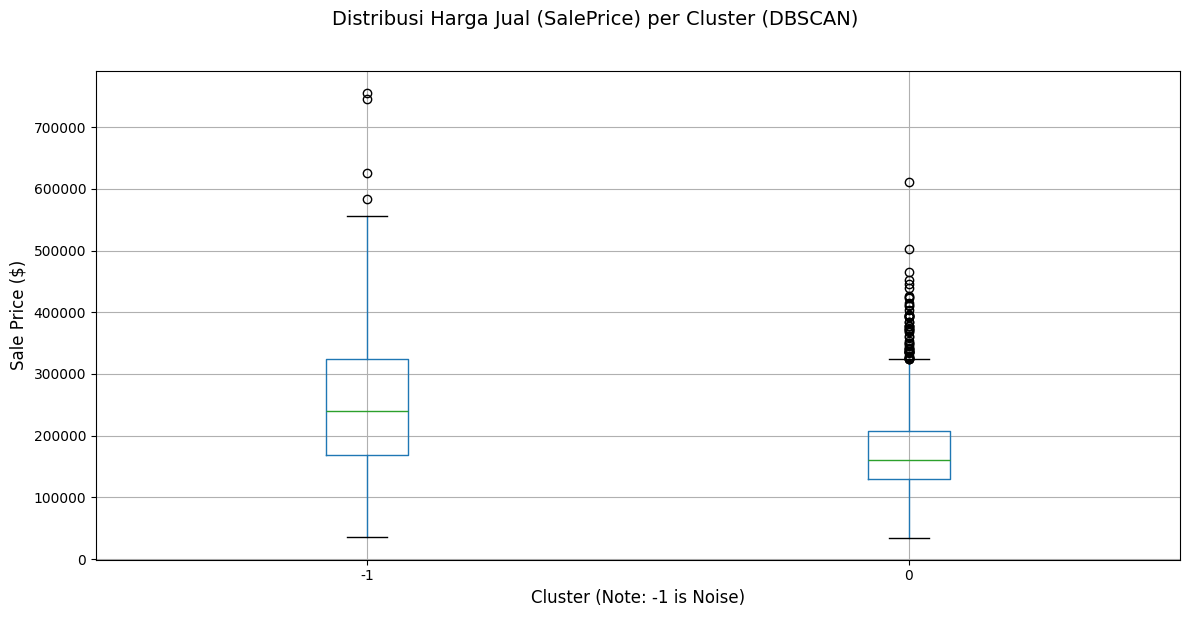

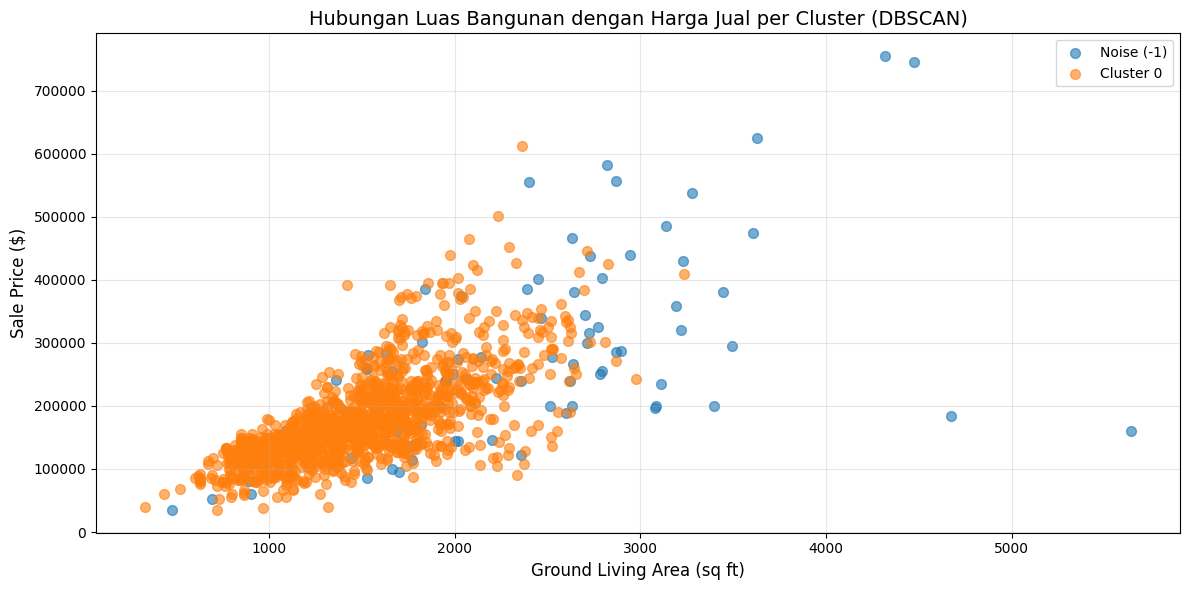

In [14]:
# MODIFIKASI 3.3: Interpretasi (Analisis Profil Cluster)
print("\n" + "="*80)
print("📊 ANALISIS PROFIL SETIAP CLUSTER (Berdasarkan Data Training)")
print("="*80)

# Add TotalSF to df_train for interpretation (Pastikan ini dijalankan jika sebelumnya terhapus)
# The TotalSF column was created in the combined dataframe (df_data) but not in df_train.
# We need to add it to df_train before analyzing cluster profiles.
df_train['TotalSF'] = df_train['TotalBsmtSF'] + df_train['1stFlrSF'] + df_train['2ndFlrSF']


# Filter klaster unik (mengeluarkan klaster Noise -1)
clusters_to_profile = [c for c in np.unique(df_train['Cluster']) if c != -1]

# Statistik deskriptif untuk setiap cluster
for cluster_id in clusters_to_profile:
    cluster_data = df_train[df_train['Cluster'] == cluster_id]
    print(f"\n{'='*80}")
    print(f"🏘️  CLUSTER {cluster_id} - Total: {len(cluster_data)} rumah ({len(cluster_data)/len(df_train)*100:.1f}% dari data TRAIN)")
    print(f"{'='*80}")

    # Statistik SalePrice
    print(f"\n💰 HARGA JUAL (SalePrice):")
    print(f"   - Rata-rata: ${cluster_data['SalePrice'].mean():,.0f}")
    print(f"   - Median   : ${cluster_data['SalePrice'].median():,.0f}")
    print(f"   - Min      : ${cluster_data['SalePrice'].min():,.0f}")
    print(f"   - Max      : ${cluster_data['SalePrice'].max():,.0f}")

    # Karakteristik fisik rumah
    print(f"\n🏠 KARAKTERISTIK FISIK:")
    print(f"   - Luas Tanah (LotArea)    : {cluster_data['LotArea'].mean():,.0f} sq ft (rata-rata)")
    print(f"   - Luas Bangunan (GrLivArea): {cluster_data['GrLivArea'].mean():,.0f} sq ft (rata-rata)")
    print(f"   - Total SF (TotalSF)      : {cluster_data['TotalSF'].mean():,.0f} sq ft (rata-rata)")
    print(f"   - Tahun Dibangun          : {cluster_data['YearBuilt'].median():.0f} (median)")
    print(f"   - Overall Quality         : {cluster_data['OverallQual'].mean():.1f}/10 (rata-rata)")

    # Informasi garasi
    print(f"\n🚗 GARASI:")
    print(f"   - Kapasitas Mobil: {cluster_data['GarageCars'].mean():.1f} mobil (rata-rata)")

    # Neighborhood paling umum
    print(f"\n📍 LOKASI (Neighborhood Terpopuler):")
    top_neighborhoods = cluster_data['Neighborhood'].value_counts().head(3)
    for idx, (neighborhood, count) in enumerate(top_neighborhoods.items(), 1):
        print(f"   {idx}. {neighborhood}: {count} rumah ({count/len(cluster_data)*100:.1f}%)")

    # Zoning paling umum
    print(f"\n🗺️  ZONA (MSZoning Terpopuler):")
    top_zoning = cluster_data['MSZoning'].value_counts().head(2)
    for idx, (zone, count) in enumerate(top_zoning.items(), 1):
        print(f"   {idx}. {zone}: {count} rumah ({count/len(cluster_data)*100:.1f}%)")

# MODIFIKASI: Tambahkan Profil Klaster Noise (-1)
noise_data = df_train[df_train['Cluster'] == -1]
if not noise_data.empty:
    print(f"\n{'='*80}")
    print(f" шумо CLUSTER NOISE (-1) - Total: {len(noise_data)} rumah ({len(noise_data)/len(df_train)*100:.1f}%)")
    print(" (Klaster ini biasanya mewakili outlier. Ciri-cirinya perlu diverifikasi.)")
    print(f" Rata-rata SalePrice Noise: ${noise_data['SalePrice'].mean():,.0f}")
    print(f" Median OverallQual Noise : {noise_data['OverallQual'].median():.1f}/10")
    print(f" Rata-rata GrLivArea Noise: {noise_data['GrLivArea'].mean():,.0f} sq ft")
    print(f" Ciri Umum: {noise_data['SaleCondition'].value_counts().idxmax()} ({noise_data['SaleCondition'].value_counts().max()} rumah)")
    print(f"{'='*80}")

print("\n" + "="*80)
print("✅ ANALISIS SELESAI!")
print("="*80)

# Visualisasi tambahan: Boxplot SalePrice per Cluster (menggunakan semua klaster)
# Mengganti K_optimal dengan klaster unik untuk plotting
K_DBSCAN_TRAIN = np.unique(df_train['Cluster']).tolist()

plt.figure(figsize=(12, 6))
# Boxplot otomatis akan mengurutkan klaster berdasarkan label, termasuk -1
df_train.boxplot(column='SalePrice', by='Cluster', figsize=(12, 6))
plt.suptitle('Distribusi Harga Jual (SalePrice) per Cluster (DBSCAN)', fontsize=14, y=1.02)
plt.title('')
plt.xlabel('Cluster (Note: -1 is Noise)', fontsize=12)
plt.ylabel('Sale Price ($)', fontsize=12)
# Menggunakan label klaster yang sebenarnya (termasuk -1)
plt.xticks(range(1, len(K_DBSCAN_TRAIN)+1), [f'{i}' for i in K_DBSCAN_TRAIN])
plt.tight_layout()
plt.savefig('dbscan_boxplot.png')
plt.show()

# Scatter plot: GrLivArea vs SalePrice dengan warna cluster
plt.figure(figsize=(12, 6))
# Mengganti K_optimal dengan klaster unik untuk loop
for cluster_id in K_DBSCAN_TRAIN:
    cluster_data = df_train[df_train['Cluster'] == cluster_id]
    label = f'Noise ({cluster_id})' if cluster_id == -1 else f'Cluster {cluster_id}'
    plt.scatter(cluster_data['GrLivArea'], cluster_data['SalePrice'],
                label=label, alpha=0.6, s=50)
plt.xlabel('Ground Living Area (sq ft)', fontsize=12)
plt.ylabel('Sale Price ($)', fontsize=12)
plt.title('Hubungan Luas Bangunan dengan Harga Jual per Cluster (DBSCAN)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('dbscan_scatterplot.png')
plt.show()

# **4) Approximate Nearest Neighbor (ANN) dengan Annoy**

## **4.1) Building Annoy Index**

In [20]:
!pip install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp312-cp312-linux_x86_64.whl size=551811 sha256=4e9d56452ab854b5702457ee7bfefec1f95abf35b8ea4f9ee3160643ab34b786
  Stored in directory: /root/.cache/pip/wheels/db/b9/53/a3b2d1fe1743abadddec6aa541294b24fdbc39d7800bc57311
Successfully built annoy


In [21]:
from annoy import AnnoyIndex

# Dimensi data (jumlah fitur setelah One-Hot Encoding dan Scaling)
f = X_final.shape[1]
print(f"\nJumlah Fitur (Dimensi) untuk Annoy Index: {f}")
print(f"Jumlah Total Data Points: {X_final.shape[0]}")

# 1. Inisialisasi Annoy Index
# 'f' adalah jumlah dimensi (fitur), 'angular' adalah metrik jarak yang umum digunakan
t = AnnoyIndex(f, 'angular')
num_trees = 10  # Hyperparameter: Jumlah pohon (semakin banyak semakin akurat, namun semakin lambat membangunnya)

# 2. Menambahkan item ke index
for i in range(X_final.shape[0]):
    t.add_item(i, X_final[i])

# 3. Membangun index
print(f"Membangun Annoy Index dengan {num_trees} pohon...")
t.build(num_trees)

print("✅ Annoy Index Berhasil Dibangun!")


Jumlah Fitur (Dimensi) untuk Annoy Index: 45
Jumlah Total Data Points: 2919
Membangun Annoy Index dengan 10 pohon...
✅ Annoy Index Berhasil Dibangun!


## **4.2) Selecting Query Points**

In [22]:
# Query Points: Pilih beberapa indeks rumah dari data training (0-1459)
# Contoh: Rumah dengan index 0, 10, 100, dan 1459 (last train index)
query_indices = [0, 10, 100, 1459]
num_neighbors = 5 # Jumlah tetangga terdekat yang ingin dicari

print(f"\n--- Mencari {num_neighbors} Tetangga Terdekat untuk Query Points ---")


--- Mencari 5 Tetangga Terdekat untuk Query Points ---


## **4.3) Searching Nearest Neighbors**

In [23]:
# Looping untuk setiap query point
for query_idx in query_indices:
    # Mengambil vektor fitur dari query point
    query_vector = X_final[query_idx]

    # Mencari tetangga terdekat
    # include_distances=True untuk mendapatkan nilai jarak (kemiripan)
    neighbor_indices, distances = t.get_nns_by_vector(
        query_vector,
        num_neighbors + 1, # +1 karena item pertama yang dikembalikan adalah query point itu sendiri
        include_distances=True
    )

    # Filter dan tampilkan hasil
    # Item pertama adalah query point itu sendiri, jadi kita lewati

    # 1. Ambil indeks dan jarak tetangga (lewatkan yang pertama)
    actual_neighbors = neighbor_indices[1:]
    actual_distances = distances[1:]

    print(f"\n========================================================")
    print(f"🔍 Query Point Index: {query_idx} (Data Asal: df_train[{query_idx}])")
    print(f"   Fitur Utama: OverallQual={df_train.loc[query_idx, 'OverallQual']}, GrLivArea={df_train.loc[query_idx, 'GrLivArea']}, SalePrice=${df_train.loc[query_idx, 'SalePrice']:,.0f}")
    print(f"========================================================")

    print(f"| Indeks Tetangga | Jarak (Angular) | Tipe Data | Kualitas (OQ) | Luas (SF) | Harga Jual |")
    print(f"|-----------------|-----------------|-----------|---------------|-----------|------------|")

    for n_idx, dist in zip(actual_neighbors, actual_distances):
        # Tentukan apakah tetangga berasal dari data 'train' atau 'test'
        data_type = 'Train' if n_idx < train_len else 'Test'
        df_index = n_idx if data_type == 'Train' else n_idx - train_len

        # Ambil SalePrice, OverallQual, dan GrLivArea untuk interpretasi
        if data_type == 'Train':
            price = f"${df_train.loc[n_idx, 'SalePrice']:,.0f}"
            qual = df_train.loc[n_idx, 'OverallQual']
            area = f"{df_train.loc[n_idx, 'GrLivArea']:,.0f}"
        else:
            # Data Test tidak memiliki SalePrice, ambil dari df_test_features
            price = "N/A"
            qual = df_test_features.loc[df_index, 'OverallQual']
            area = f"{df_test_features.loc[df_index, 'GrLivArea']:,.0f}"

        print(f"| {n_idx:<15} | {dist:<15.4f} | {data_type:<9} | {qual:<13} | {area:<9} | {price:<10} |")

print("\n🎉 Proses ANN Selesai!")


🔍 Query Point Index: 0 (Data Asal: df_train[0])
   Fitur Utama: OverallQual=7, GrLivArea=1710, SalePrice=$208,500
| Indeks Tetangga | Jarak (Angular) | Tipe Data | Kualitas (OQ) | Luas (SF) | Harga Jual |
|-----------------|-----------------|-----------|---------------|-----------|------------|
| 1240            | 0.1173          | Train     | 7             | 1,768     | $224,900   |
| 1366            | 0.1427          | Train     | 7             | 1,790     | $193,000   |
| 2167            | 0.3585          | Test      | 6             | 1,771     | N/A        |
| 518             | 0.4509          | Train     | 6             | 1,796     | $211,000   |
| 2169            | 0.4562          | Test      | 7             | 1,823     | N/A        |

🔍 Query Point Index: 10 (Data Asal: df_train[10])
   Fitur Utama: OverallQual=5, GrLivArea=1040, SalePrice=$129,500
| Indeks Tetangga | Jarak (Angular) | Tipe Data | Kualitas (OQ) | Luas (SF) | Harga Jual |
|-----------------|-----------------|---